In [1]:
import wandb

wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: khk172216 (toez). Use `wandb login --relogin` to force relogin


True

# working model for tensorfusion

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
from glob import glob
from collections import Counter

from datasets import Dataset

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split


print(torch.__version__)

/home/40toez/project/kyungho/multi_modal/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.13.1+cu117


In [64]:
# Hyperparameters
BATCH_SIZE = 256
EPOCHS = 40
LR = 1e-2

In [3]:
# Root 경로 설정
ROOT = "/home/40toez/project/kyungho/multi_modal/"

In [4]:
# Annotation, embedded data 불러오기
with open(ROOT + 'model/data/paradeigma_KEMDY20_annotation_nonmissing.pkl', 'rb') as f:
    annotation_20_nonmissing = pickle.load(f)

with open(ROOT + 'model/data/paradeigma_KEMDY19_annotation_nonmissing.pkl', 'rb') as f:
    annotation_19_nonmissing = pickle.load(f)

ROOT = "/home/40toez/project/kyungho/multi_modal/"
with open(ROOT + 'model/data/paradeigma_KEMDY20_embedding_for_dataset.pkl', 'rb') as f:
    embedding_20_dataset = pickle.load(f)

with open(ROOT + 'model/data/paradeigma_KEMDY19_embedding_for_dataset.pkl', 'rb') as f:
    embedding_19_dataset = pickle.load(f)

In [5]:
# Annotation 파일 결합
raw_dataset = pd.DataFrame()
raw_dataset = raw_dataset.append(annotation_19_nonmissing, ignore_index = True)
raw_dataset = raw_dataset.append(annotation_20_nonmissing, ignore_index = True)
merged_dataset = raw_dataset

/tmp/ipykernel_24999/4239242207.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  raw_dataset = raw_dataset.append(annotation_19_nonmissing, ignore_index = True)
/tmp/ipykernel_24999/4239242207.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  raw_dataset = raw_dataset.append(annotation_20_nonmissing, ignore_index = True)


In [6]:
# Wav, txt data 분리
merged_embeddings = {'wav':[], 'txt':[]}
for session, embeddings in embedding_19_dataset[0].items():
    merged_embeddings['wav'].append(embeddings)
    
for session, embeddings in embedding_19_dataset[1].items():
    merged_embeddings['txt'].append(embeddings)
    
for session, embeddings in embedding_20_dataset[0].items():
    merged_embeddings['wav'].append(embeddings)
    
for session, embeddings in embedding_20_dataset[1].items():
    merged_embeddings['txt'].append(embeddings)

In [7]:
# Wav txt 2020 + 2019
merged_embeddings['wav'] = torch.concat(merged_embeddings['wav'])
merged_embeddings['txt'] = torch.concat(merged_embeddings['txt'])

In [8]:
# 확인
merged_embeddings['wav'].shape,merged_embeddings['txt'].shape,len(merged_dataset)

(torch.Size([21723, 149, 1024]), torch.Size([21723, 80, 768]), 21723)

In [10]:
# Padding 함수
def sequence_padding(ts_list, padding_length = 50, mode = 'constant'):
    
    padding_value=0
    
    if (type(ts_list) != type([])) :
        ts_list = [padding_value] * padding_length
    
    elif len(ts_list) >= padding_length :
        ts_list = ts_list[0:padding_length]
    
    elif mode == 'constant':
        length = padding_length - len(ts_list)
        extend_list = [padding_value] * length
        ts_list = ts_list + extend_list    

    elif mode == 'replicate':
        
        quotient = padding_length // len(ts_list)
        remainder = padding_length % len(ts_list)
        result = ts_list * quotient
        result += ts_list[:remainder]
        ts_list = result

    return ts_list            

In [11]:
# 시계열 데이터 2020 + 2019
merged_dataset['Scaled EDA'] = merged_dataset['Scaled EDA'].apply(sequence_padding)
merged_dataset['Scaled TEMP'] = merged_dataset['Scaled TEMP'].apply(sequence_padding)

# torch dataset 만들기
- 참고: https://tutorials.pytorch.kr/beginner/basics/data_tutorial.html

In [12]:
class EtriDataset(Dataset):
    def __init__(self, file_names, 
                 text_embeddings, 
                 wav_embeddings, 
                 Temp,
                 EDA,
                 Emotion,
                 Emotion_ext, 
                 Arousal, 
                 Valence):
        self.file_names = file_names
        self.text_embeddings = text_embeddings
        self.wav_embeddings = wav_embeddings
        self.temp = Temp
        self.eda = EDA
        self.label_emotion = Emotion
        self.label_emotion_ext = Emotion_ext
        self.label_arousal = Arousal
        self.label_valence = Valence
        
    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        text_embeddings = self.text_embeddings[idx]
        wav_embeddings = self.wav_embeddings[idx]
        temp = self.temp[idx]
        eda = self.eda[idx]
        label_emotion = self.label_emotion[idx]
        label_emotion_ext = self.label_emotion_ext[idx]
        label_arousal = self.label_arousal[idx]
        label_valence = self.label_valence[idx]
        return text_embeddings, wav_embeddings, temp, eda, label_emotion, label_emotion_ext, label_arousal, label_valence

In [45]:
# data load 및 나누기: https://076923.github.io/posts/Python-pytorch-11/

# session을 통합시킨 데이터 셋을 만들었을 때
dataset = EtriDataset(file_names = merged_dataset['Segment ID'],
                      text_embeddings = merged_embeddings['txt'],
                      wav_embeddings = merged_embeddings['wav'],
                      Emotion = merged_dataset['Emotion'],
                      Arousal = merged_dataset['Arousal'].apply(lambda x : torch.tensor(x)),
                      Valence = merged_dataset['Valence'].apply(lambda x : torch.tensor(x)),
                      EDA = torch.concat(list(merged_dataset['Scaled EDA'].apply(lambda x: torch.tensor(x).view(1,-1)))), ## 일부 세션 데이터만 사용하므로, 길이를 맞춰주기 위해 일부 slicing함
                      Temp = torch.concat(list(merged_dataset['Scaled EDA'].apply(lambda x: torch.tensor(x).view(1,-1)))), ## 일부 세션 데이터만 사용하므로, 길이를 맞춰주기 위해 일부 slicing함
                      Emotion_ext = torch.concat(list(merged_dataset['Scaled EDA'].apply(lambda x: torch.tensor(x).view(1,-1))))
                      ) 


In [19]:
# Train/validation/test 데이터 분할
dataset_size = len(dataset)
train_size = int(dataset_size * 0.7)
validation_size = int(dataset_size * 0.15)
test_size = dataset_size - train_size - validation_size

train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])

print(train_size, test_size, validation_size)
print(f"Training Data Size : {len(train_dataset)}")
print(f"Validation Data Size : {len(validation_dataset)}")
print(f"Testing Data Size : {len(test_dataset)}")

15206 3259 3258
Training Data Size : 15206
Validation Data Size : 3258
Testing Data Size : 3259


In [20]:
# data size
merged_embeddings['wav'][0].shape , torch.Tensor(merged_dataset['EDA'][0]).shape
# raw_dataset[session]['wav_embeddings'][0].shape


(torch.Size([149, 1024]), torch.Size([33]))

In [21]:
# Dataloader 선언
train_dataloader = DataLoader(train_dataset, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True, 
                              drop_last=True)
validation_dataloader = DataLoader(validation_dataset, 
                                   batch_size=BATCH_SIZE, 
                                   shuffle=True, 
                                   drop_last=True)
test_dataloader = DataLoader(test_dataset, 
                             batch_size=BATCH_SIZE, 
                             shuffle=True, 
                             drop_last=True)

# NetWork 만들기

In [44]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
# print(f"Using {device} device")

# CUDA error: CUBLAS_STATUS_INVALID_VALUE when calling cublasSgemm( handle, opa, opb, m, n, k, &alpha, a, lda, b, ldb, &beta, c, ldc)
# 위의 오류가 해결되기 전까진 일단 cpu를 가지고 모델을 돌리기로 한다. 
device = 'cpu'


In [41]:
class MLPNetwork_pre(nn.Module):
    def __init__(self, input_length, input_width):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_length*input_width, 768)
        self.gelu1 = nn.GELU()
        self.bn1 = nn.BatchNorm1d(768)
        self.fc2 = nn.Linear(768, 512)
        self.gelu2 = nn.GELU()
        self.bn2 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 32)
        self.gelu3 = nn.GELU()
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.gelu1(x)
        x = self.bn1(x)
        x = self.fc2(x)
        x = self.gelu2(x)
        x = self.bn2(x)
        x = self.fc3(x)
        output = self.gelu3(x)
        return output
    
class ConvNetwork_pre(nn.Module):
    def __init__(self, input_channel):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels = input_channel, out_channels= 32, kernel_size = 3, padding = 1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels = 32, out_channels = 10, kernel_size = 3, padding = 1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        output = self.relu2(x)
        return output

# b, 50, 1-> (b, 1,50) -> conv1d(1,1,16) -> conv1d(1,1,16) -> (b, 1, 21)
#                                                                     concat(dim=1) (b,2,21) -> conv1d(input_dim = 2, output_dim = 1 , kernel = 12 ) -> (b,1,10)  -> (b,10,1) 
# b, 50, 1 -> (b,1,50) -> conv1d(1,1,16) -> conv1d(1,1,16) -> (b, 1, 21)
# class ConvNetwork_middle(nn,Module):

class ConvNetwork_final(nn.Module):
    def __init__(self, input_channel):
        super().__init__()
        self.conv2d_1 = nn.Conv2d(in_channels = input_channel, out_channels = 64, kernel_size=2)
        self.leakyrelu_1 = nn.LeakyReLU()
        self.maxpool2d_1 = nn.MaxPool2d(2)
        self.conv2d_2 = nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size=2)
        self.leakyrelu_2 = nn.LeakyReLU()
        self.maxpool2d_2 = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(224, 64)
        self.leakyrelu_3 = nn.LeakyReLU()
        self.batchnorm = nn.BatchNorm1d(64)
        self.drop = nn.Dropout(p=0.25)
        self.fc2 = nn.Linear(64, 2)
        
    def forward(self, x):
        x = self.conv2d_1(x)
        x = self.leakyrelu_1(x)
        x = self.maxpool2d_1(x)
        x = self.conv2d_2(x)
        x = self.leakyrelu_2(x)
        x = self.maxpool2d_2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.leakyrelu_3(x)
        x = self.batchnorm(x)
        x = self.drop(x)
        output = self.fc2(x)  
        return output
        



In [24]:
class TensorFusionMixer(nn.Module):
    def __init__(self, ModelA, ModelB, ModelC, ModelD, ModelE):
        super().__init__()
        self.ModelA = ModelA
        self.ModelB = ModelB
        self.ModelC = ModelC
        self.ModelD = ModelD
        self.Model_cnn_final = ModelE
        # self.softmax = nn.Softmax(dim=1)
        
    def tensor_fusion(self, batch_arr1, batch_arr2, batch_arr3):
        fusion_matrix_lst = []
        for i, (arr1, arr2, arr3) in enumerate(zip(batch_arr1, batch_arr2, batch_arr3)):
            arr1 = arr1.unsqueeze(-1).unsqueeze(-1)
            arr2 = arr2.unsqueeze(0).unsqueeze(-1)
            arr3 = arr3.squeeze().unsqueeze(0).unsqueeze(0)
            
            # outer_matrix = torch.einsum('i,j,kp->ijk', arr1, arr2, arr3)
            kron_matrix = torch.kron(torch.kron(arr1,arr2), arr3)
            l, w, d = kron_matrix.shape
            
            kron_matrix = kron_matrix.view(-1, l, w, d)
            fusion_matrix_lst.append(kron_matrix)
            
        fusion_matrix = torch.concat(fusion_matrix_lst)
        # fusion_matrix = fusion_matrix.unsqueeze(-1)
        
        return fusion_matrix
        
    def forward(self, x1, x2, x3, x4):
        x1 = self.ModelA(x1)
        x2 = self.ModelB(x2)
        x3 = self.ModelC(x3)
        x4 = self.ModelD(x4)
        
        x5 = torch.cat([x3,x4], dim=0)
        fusion_matrix = self.tensor_fusion(x1, x2, x5)
        
        output = self.Model_cnn_final(fusion_matrix) 
        return output

In [79]:
# txt_input_length, txt_input_width = raw_dataset[session]['text_embeddings'][0].shape | 마지막엔 지울 것
# _, wav_input_length, wav_input_width = raw_dataset[session]['wav_embeddings'][0].shape
txt_input_length, txt_input_width = dataset.text_embeddings[0].shape
wav_input_length, wav_input_width = dataset.wav_embeddings[0].shape
temp_input_length = dataset.temp[0].shape[0]
eda_input_length = dataset.eda[0].shape[0]
# temp_input_length = 1
# eda_input_length = 1

# tf_mixer에 들어갈 wav mlp, txt mlp 선언
model_mlp_txt = MLPNetwork_pre(txt_input_length, txt_input_width).to(device)
model_mlp_wav = MLPNetwork_pre(wav_input_length, wav_input_width).to(device)
model_conv_temp = ConvNetwork_pre(temp_input_length).to(device)
model_conv_eda = ConvNetwork_pre(eda_input_length).to(device)

model_cnn_final = ConvNetwork_final(32).to(device)

# 최종 모델 선언
model_tf_cnn_mixer = TensorFusionMixer(ModelA = model_mlp_txt, 
                                   ModelB = model_mlp_wav,
                                   ModelC = model_conv_temp,
                                   ModelD = model_conv_eda,
                                   ModelE = model_cnn_final).to(device)

# model 병렬 학습 처리
# 쿠다 문제가 고쳐졌을 경우에만 아래의 코드의 주석을 해제해서 실행한다. 
# if torch.cuda.device_count() > 1:
#     print("Let's use", torch.cuda.device_count(), "GPUs!")
#     model_mlp_txt = nn.DataParallel(model_mlp_txt).to(device)
#     model_mlp_wav = nn.DataParallel(model_mlp_wav).to(device)
#     model_conv_temp = nn.DataParallel(model_conv_temp).to(device)
#     model_conv_eda = nn.DataParallel(model_conv_eda).to(device)
#     model_tf_cnn_mixer = nn.DataParallel(model_tf_cnn_mixer).to(device)
    
print(model_tf_cnn_mixer)

TensorFusionMixer(
  (ModelA): MLPNetwork_pre(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc1): Linear(in_features=61440, out_features=768, bias=True)
    (gelu1): GELU(approximate='none')
    (bn1): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc2): Linear(in_features=768, out_features=512, bias=True)
    (gelu2): GELU(approximate='none')
    (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc3): Linear(in_features=512, out_features=32, bias=True)
    (gelu3): GELU(approximate='none')
  )
  (ModelB): MLPNetwork_pre(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc1): Linear(in_features=152576, out_features=768, bias=True)
    (gelu1): GELU(approximate='none')
    (bn1): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc2): Linear(in_features=768, out_features=512, bias=True)
    (gelu2): GELU(approximate='none')
    (bn2): BatchNorm1d(512, eps=1e-

In [51]:
import torch

def covariance(x, y):
    x_mean = torch.mean(x)
    y_mean = torch.mean(y)
    return torch.mean((x - x_mean) * (y - y_mean))

def ccc(arousal_valence_A, arousal_valence_B):
    # Calculate means
    mean_A = torch.mean(arousal_valence_A, axis=0)
    mean_B = torch.mean(arousal_valence_B, axis=0)

    # Calculate variances
    var_A = torch.var(arousal_valence_A, axis=0, unbiased=True)
    var_B = torch.var(arousal_valence_B, axis=0, unbiased=True)

    # Calculate covariance
    cov_arousal = covariance(arousal_valence_A[:, 0], arousal_valence_B[:, 0])
    cov_valence = covariance(arousal_valence_A[:, 1], arousal_valence_B[:, 1])

    # Calculate CCC for arousal and valence components
    ccc_arousal = (2 * cov_arousal) / (var_A[0] + var_B[0] + (mean_A[0] - mean_B[0]) ** 2)
    ccc_valence = (2 * cov_valence) / (var_A[1] + var_B[1] + (mean_A[1] - mean_B[1]) ** 2)

    # Average the CCCs for arousal and valence components
    ccc = (ccc_arousal + ccc_valence) / 2

    return ccc

In [52]:
class CCCLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self,inputs,targets):
        self.inputs = inputs
        self.targets = targets
        # pred_v = inputs[:,0]
        # pred_a = inputs[:,1]
        # y_v  = targets[:,0]
        # y_a  = targets[:,1]

        return 1 - ccc(self.inputs, self.targets )
    
cccl = CCCLoss()

# 학습을 위한 train, test method 만들기

In [85]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)    
    # data 순서: text_embeddings, wav_embeddings, temp, eda, label_emotion, label_emotion_ext, label_arousal, label_valence
    for batch, (X_txt, X_wav, X_temp, X_eda, 
                    label_emotion, label_emotion_ext, label_arousal, label_valence) in enumerate(dataloader): 

        # 예측 오류 계산 
        X_txt, X_wav, X_temp, X_eda, y_v, y_a= X_txt.to(device), X_wav.to(device), X_temp.to(device), X_eda.to(device),label_valence.type(torch.float32).to(device), label_arousal.type(torch.float32).to(device)
        
        X_temp = X_temp.unsqueeze(dim=-1)
        X_eda = X_eda.unsqueeze(dim=-1)
        y_v = y_v.unsqueeze(dim=-1)
        y_a = y_a.unsqueeze(dim=-1)
        
        pred = model(X_txt, X_wav, X_temp, X_eda)
    
        # pred_v = pred[:,0].unsqueeze(dim=-1)
        # pred_a = pred[:,1].unsqueeze(dim=-1)
        
        y = torch.concat([y_v, y_a], dim=-1)

        
        # # loss_a = loss_fn(pred_a, y_a)
        # # loss_v = loss_fn(pred_v, y_v)
        # loss = loss_fn(pred, y)
        
        # pred_ccc_v= ccc(pred_v, y_v)
        # pred_ccc_a = ccc(pred_a, y_a)
        
        loss = loss_fn(pred, y)
        
        # ccc_mean = (pred_ccc_a + pred_ccc_v) / 2
        

        # 역전파
        optimizer.zero_grad()
        loss.backward()
        # loss_a.backward(retain_graph = True)
        # loss_v.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X_txt)
            # loss_a, loss_v, current = loss_a.item(), loss_v.item(), batch * len(X_txt)
            # print(f"loss_a: {loss_a:>7f}, loss_v: {loss_v:>7f}")
            print(f"loss: {loss}")
            # print(f"ccc_mean : {ccc_mean.item():>9f}, Arousal_ccc : {pred_ccc_a.item():>9f}, Valence_ccc : {pred_ccc_v.item():>9f}".format())

    # wandb.log({'loss':loss,'ccc_mean':ccc_mean.item(),'ccc_valence' : pred_ccc_v.item(),'ccc_arousal' : pred_ccc_a.item()})    

In [86]:
def test(dataloader, model, loss_fn, mode = 'test'):
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    # test_loss_a = 0
    # test_loss_v = 0
    # ccc_mean = 0
    # ccc_a = 0
    # ccc_v = 0
    
    with torch.no_grad():
        # data 순서: text_embeddings, wav_embeddings, temp, eda, label_emotion, label_emotion_ext, label_arousal, label_valence
        for batch, (X_txt, X_wav, X_temp, X_eda, 
                    label_emotion, label_emotion_ext, label_arousal, label_valence) in enumerate(dataloader): 

            # 예측 오류 계산 
            X_txt, X_wav, X_temp, X_eda, y_v, y_a= X_txt.to(device), X_wav.to(device), X_temp.to(device), X_eda.to(device),label_valence.type(torch.float32).to(device), label_arousal.type(torch.float32).to(device)
            
            X_temp = X_temp.unsqueeze(dim=-1)
            X_eda = X_eda.unsqueeze(dim=-1)
            y_v = y_v.unsqueeze(dim=-1)
            y_a = y_a.unsqueeze(dim=-1)

            pred = model(X_txt, X_wav, X_temp, X_eda)
            
            # pred_v = pred[:,0].unsqueeze(dim=-1)
            # pred_a = pred[:,1].unsqueeze(dim=-1)
            y = torch.concat([y_v, y_a], dim=-1)

            
            loss = loss_fn(pred, y)
            test_loss += loss
            
            # loss_a = loss_fn(pred_a, y_a)
            # loss_v = loss_fn(pred_v, y_v)

            # test_loss_a += loss_a
            # test_loss_v += loss_v

            # pred_ccc_a = ccc(pred_a, y_a)
            # pred_ccc_v = ccc(pred_v, y_v)
            
            # ccc_a += pred_ccc_a
            # ccc_v += pred_ccc_v
      
      
    test_loss /= num_batches  
    # test_loss_v /= num_batches    
    # test_loss_a /= num_batches
    
    # ccc_v /= num_batches
    # ccc_a /= num_batches
    # ccc_mean = (ccc_a + ccc_v) / 2

    
    if mode == 'test':
        # print(f"loss_a: {loss_a:>7f}, loss_v: {loss_v:>7f}")
        print(f"loss: {test_loss:>7f}")
        # print(f"Test ccc_mean : {ccc_mean.item():>9f}, Arousal_ccc : {pred_ccc_a.item():>9f}, Valence_ccc : {pred_ccc_v.item():>9f}")
    elif mode == 'val':
        # print(f"loss_a: {loss_a:>7f}, loss_v: {loss_v:>7f}")
        print(f"loss: {test_loss:>7f}")
        # print(f"Val ccc_mean : {ccc_mean.item():>9f}, Arousal_ccc : {pred_ccc_a.item():>9f}, Valence_ccc : {pred_ccc_v.item():>9f}")
        # wandb.log({'loss':loss,'ccc_mean':ccc_mean.item(),'ccc_valence' : pred_ccc_v.item(),'ccc_arousal' : pred_ccc_a.item()})
    return test_loss

# 학습시키기

In [ ]:
# # 지난 저장한 모델이 있다면
# PATH = './data/test_model.pkl'
# model_tf_mixer = torch.load(PATH)

## start training mlp fusion mixer

In [84]:
# Set the Training Parameters

criterion =  CCCLoss()# nn.MSELoss()
optimizer = optim.SGD(model_tf_cnn_mixer.parameters(), lr=LR) # regression
epochs = EPOCHS

In [82]:
criterion.__class__.__name__

'CCCLoss'

In [61]:
# run = wandb.init(
#     # Set the project where this run will be logged
#     project="ETRI_regression",
#     # Track hyperparameters and run metadata
#     config={
#         "Learning rate": LR,
#         "Epochs": EPOCHS,
#         # "Optimizer": optimizer.__class__.__name__,
#         "Loss": criterion.__class__.__name__
#     })

IndexError: too many indices for tensor of dimension 1

In [88]:
loss_history_train = {}
loss_history_val = {}

for epoch in range(EPOCHS):
    print(f"---------------Epoch {epoch+1}----------------")
    print("Training...............")
    train(train_dataloader,
                 model_tf_cnn_mixer, 
                 criterion, 
                 optimizer)
    loss_history_train[epoch+1] = loss_train
    print("Validation.............")
    loss_val = test(validation_dataloader, 
                    model_tf_cnn_mixer, 
                    criterion, 
                    mode='val')
    loss_history_val[epoch+1] = loss_val
print("Done!")

---------------Epoch 1----------------
Training...............
loss: 0.9937795996665955
Validation.............
loss: 0.992137
---------------Epoch 2----------------
Training...............
loss: 0.9976429343223572
Validation.............
loss: 0.984033
---------------Epoch 3----------------
Training...............
loss: 0.9898079037666321
Validation.............
loss: 0.973675
---------------Epoch 4----------------
Training...............
loss: 0.9956458806991577
Validation.............
loss: 0.961297
---------------Epoch 5----------------
Training...............
loss: 1.0029641389846802
Validation.............
loss: 0.903185
---------------Epoch 6----------------
Training...............
loss: 0.9747762680053711
Validation.............
loss: 0.885398
---------------Epoch 7----------------
Training...............
loss: 0.8619399070739746
Validation.............
loss: 0.865770
---------------Epoch 8----------------
Training...............
loss: 0.9033898711204529
Validation.............

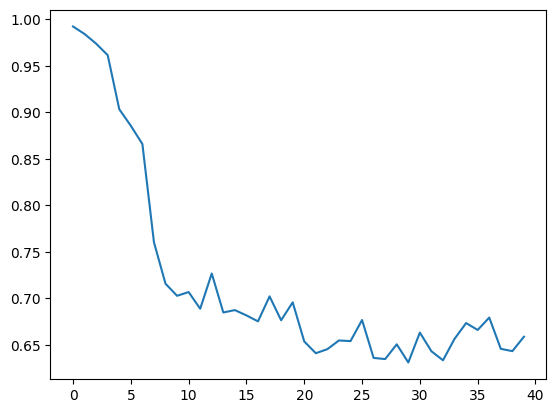

In [89]:
import matplotlib.pyplot as plt

plt.plot(loss_history_val.values())

In [ ]:
# 실험을 위해 모델 저장
PATH = '.model/data/paradeigma_test_model_multilabel_CNN.pkl'
torch.save(model_tf_cnn_mixer, PATH)

## basic TensorFusionNet 검증